In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import operator
from statsmodels.tsa.seasonal import seasonal_decompose
from pyramid.arima import auto_arima

In [2]:
PATH = "/home/tom/"
FILE = "store_sales_by_OLG-pre.csv"   # This is JLP data
TEST_WEEKS = 26

In [3]:
# Get the MAPE between the inputs
def getMAPE(compare, test):
    diff = np.abs(compare-test)
    MAPE = diff.values/test
    return MAPE.mean()

In [4]:
# Use JLP sales data
df = pd.read_csv(PATH+FILE, names=["store", "week", "sales"], header=0)

# Aggregate the data so it's in format [Week, sales]
sales = df.groupby(["week"])["sales"].sum()

# Something weird happened the last 6 weeks so discard
sales = sales[:-6]
# Get rid of "2017(03)" as the index and use sequence
idx = [x for x in range(len(sales))]
sales.index=idx

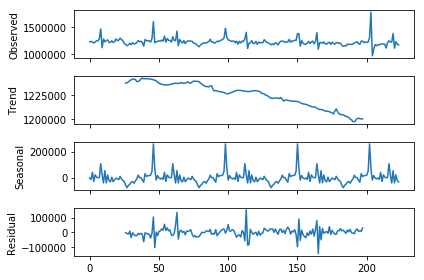

In [5]:
result = seasonal_decompose(sales, model="additive", freq=52)
result.plot()

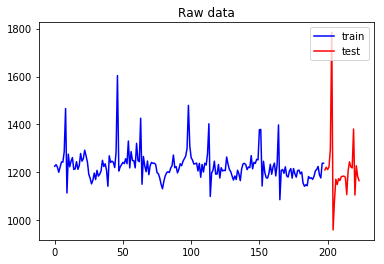

In [6]:
# Create Train and Test sets
train = sales[:-TEST_WEEKS]
test  = sales[-TEST_WEEKS:]
# Make sure splitting train & test didn't lose any data
assert (sales.sum() - train.sum() - test.sum() < 0.1 )

plt.close()
plt.plot(train/1000, color = "b", label="train")
plt.plot(test/1000, color = "r", label="test")
plt.legend(loc='upper right')
plt.title("Raw data")
plt.show()

In [16]:
model = auto_arima(sales, start_p=1, start_q=1,
                           max_p=13, max_q=5, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=None, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

5721.735892980902


In [17]:
model.fit(train)

ValueError: non-invertible starting seasonal moving average parameters found with `enforce_invertibility` set to True.

In [12]:
forecast = model.predict(n_periods=TEST_WEEKS)
score = getMAPE(forecast, test)
print("Best performance was with MAPE: {:.2%}, \
ARIMA order: {}, Seasonal order: {}".\
      format(score, model.order, model.seasonal_order))

Best performance was with MAPE: 6.54%, ARIMA order: (1, 1, 0), Seasonal order: (2, 1, 0, 52)


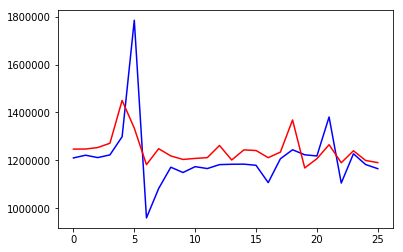

In [13]:
plt.plot(test.values, color="b")
plt.plot(forecast, color="r")
plt.show()

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm
lowest = 99999

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < lowest:
            lowest = results.aic
            save = (param, param_seasonal)
print('ARIMA{}x{}12 - AIC:{}'.format(save[0], save[1], lowest))

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=save[0],
                                seasonal_order=save[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results=mod.fit()

In [ ]:
print(results.__doc__)

In [ ]:
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()